# Setup

In [ ]:
%pip install torch-geometric

In [6]:
import os
import math
import time
import psutil
import random
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [7]:
random_seed = 42

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(random_seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

using cpu


In [8]:
def compute_path_lengths(data):
    longest_path = 0
    shortest_path = float('inf')
    average_paths = []

    # Check if the data is a single graph or a dataset of graphs
    if isinstance(data, list) or isinstance(data, DataLoader):
        graphs = data
    else:
        graphs = [data]

    for graph in graphs:
        G = to_networkx(graph, to_undirected=True)
        
        # Compute shortest path lengths
        path_lengths = dict(nx.all_pairs_shortest_path_length(G))
        graph_longest_path = 0
        graph_total_path_length = 0
        graph_total_paths = 0
        
        for lengths in path_lengths.values():
            for length in lengths.values():
                if length > graph_longest_path:
                    graph_longest_path = length
                if length < shortest_path:
                    shortest_path = length
                graph_total_path_length += length
                graph_total_paths += 1

        # Update the overall longest path
        if graph_longest_path > longest_path:
            longest_path = graph_longest_path

        # Calculate the average path length for this graph
        if graph_total_paths > 0:
            graph_average_path = graph_total_path_length / graph_total_paths
            average_paths.append(graph_average_path)
    
    overall_average_path = np.mean(average_paths) if average_paths else 0
    std_average_path = np.std(average_paths) if average_paths else 0
    shortest_path = shortest_path if shortest_path != float('inf') else 0
    
    return int(longest_path), int(shortest_path), overall_average_path, std_average_path


# Graph Classification

In [11]:
# Load the MUTAG dataset
mutag_data = TUDataset(root='/tmp/MUTAG', name='MUTAG')

# Split the dataset into train, validation, and test sets
train_val_data, test_data = train_test_split(mutag_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# Create data loaders
mutag_train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
mutag_val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
mutag_test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Get the number of features and classes from the dataset
num_features = mutag_data.num_features
num_classes = mutag_data.num_classes
print(f'Num Features = {num_features}, Num Classes = {num_classes}')

Num Features = 7, Num Classes = 2


In [12]:
# Compute path lengths for the train loader
longest_path, shortest_path, overall_average_path, std_average_path = compute_path_lengths(mutag_train_loader)
print(f'MUTAG dataset - Longest path: {longest_path}')
print(f'MUTAG dataset - Shortest path: {shortest_path}')
print(f'MUTAG dataset - Overall average path: {overall_average_path:.2f}')
print(f'MUTAG dataset - Standard deviation of average paths: {std_average_path:.2f}')

MUTAG dataset - Longest path: 15
MUTAG dataset - Shortest path: 0
MUTAG dataset - Overall average path: 3.67
MUTAG dataset - Standard deviation of average paths: 0.06


## Model Definition

### Models

#### GCN

In [13]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, 64)
        self.gcn2 = GCN(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### GCESN

In [21]:
class GCESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=5):
        super(GCESN_var1, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(adj, torch.mm(h, self.W)))
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=6):
        super(GCESN_var2, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(x, self.W) + torch.mm(adj, torch.mm(h, self.W)))
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### GCN-ESN

In [59]:
class GCNESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var1, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        n_node, _ = x.shape 
        
        # # initialize state with zero
        state = torch.zeros(n_node, self.hidden_features)
        # state = x
        # print(f'state shape: {state.shape}, x shape: {x.shape}, Win shape: {self.Win.shape}, W shape: {self.W.shape}')
        
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))

        x = global_mean_pool(state, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class GCNESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var2, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        n_node, _ = x.shape 
        
        # # initialize state with zero
        state = torch.zeros(n_node, self.hidden_features)
        
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        x = F.relu(self.gcn2(state, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Utilities

In [75]:
def train_graph(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, save_path='models/gcn_x.pth'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        for data in loader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch = val_data.x, val_data.edge_index, val_data.batch
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, val_data.y).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch {epoch + 1}, Train Loss: {epoch_loss}, Val Loss: {val_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')

    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(save_path))
    print(f'Model saved to {save_path}')

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage = np.mean(cpu_usage)
    avg_memory_usage = np.mean(memory_usage)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage = np.max(cpu_usage)
    max_memory_usage = np.max(memory_usage)

    print(f'Average Time per Epoch: {avg_epoch_time:.2f}s')
    print(f'Average CPU Usage: {avg_cpu_usage:.2f}GB')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')

    print(f'\nTotal Training Time: {total_training_time:.2f}s')
    print(f'Max CPU Usage: {max_cpu_usage:.2f}GB')
    print(f'Max Memory Usage: {max_memory_usage:.2f}GB')

    return
    # return training_loss[-1], total_training_time, avg_cpu_usage, avg_memory_usage, max_cpu_usage, max_memory_usage 

def evaluate(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    
    return accuracy, sensitivity, specificity
    
def test_graph(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate(y_true, y_pred)
    # return accuracy, sensitivity, specificity
    return

In [68]:
def train_and_evaluate_multiple_runs_graph(model, train_loader, val_loader, num_runs=50, num_epochs=500, path='models/multiple_run/gcesn_v1_graph_'):
    all_accuracies = []
    all_sensitivities = []
    all_specificities = []
    all_training_times = []
    all_avg_cpu_usages = []
    all_avg_memory_usages = []
    all_max_cpu_usages = []
    all_max_memory_usages = []

    for run in range(num_runs):
        # Train the model
        save_path = path + f'_run{run}.pth'
        loss, training_time, avg_cpu, avg_memory, max_cpu, max_memory = train_graph(model, train_loader, val_loader, lr=0.01, num_epochs=num_epochs, save_path=save_path)
        
        # Test the model
        accuracy, sensitivity, specificity = test_graph(model, mutag_test_loader)

        # Store results
        all_accuracies.append(accuracy)
        all_sensitivities.append(sensitivity)
        all_specificities.append(specificity)
        all_training_times.append(training_time)
        all_avg_cpu_usages.append(avg_cpu)
        all_avg_memory_usages.append(avg_memory)
        all_max_cpu_usages.append(max_cpu)
        all_max_memory_usages.append(max_memory)

        print(f'\nRun {run+1}/{num_runs} -> Loss: {loss}')
        print(f'  Total Training Time: {training_time:.2f}s, Avg CPU Usage: {avg_cpu:.2f}GB, Avg Memory Usage: {avg_memory:.2f}GB, Max CPU Usage: {max_cpu:.2f}GB, Max Memory Usage: {max_memory:.2f}GB')
        print(f'  Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')

    # Compute average values across all runs
    avg_accuracy = np.mean(all_accuracies)
    avg_sensitivity = np.mean(all_sensitivities)
    avg_specificity = np.mean(all_specificities)
    avg_training_time = np.mean(all_training_times)
    avg_cpu_usage = np.mean(all_avg_cpu_usages)
    avg_memory_usage = np.mean(all_avg_memory_usages)
    avg_max_cpu_usage = np.mean(all_max_cpu_usages)
    avg_max_memory_usage = np.mean(all_max_memory_usages)

    print('Overall Results:')
    print(f'  Avg Accuracy: {avg_accuracy:.4f}, Avg Sensitivity: {avg_sensitivity:.4f}, Avg Specificity: {avg_specificity:.4f}')
    print(f'  Avg Training Time: {avg_training_time:.2f}s, Avg CPU Usage: {avg_cpu_usage:.2f}GB, Avg Memory Usage: {avg_memory_usage:.2f}GB, Avg Max CPU Usage: {avg_max_cpu_usage:.2f}GB, Avg Max Memory Usage: {avg_max_memory_usage:.2f}GB')

## Training

### GCN

#### GCN 1-Layer

GCN1Layer(
  (gcn1): GCN (7 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 1284

Epoch 1, Train Loss: 92.2318302989006, Val Loss: 11.303505599498749
Time: 0.03s, CPU: 1.07GB, Memory: 2.77GB
Epoch 2, Train Loss: 82.44051188230515, Val Loss: 11.97761356830597
Time: 0.01s, CPU: 1.46GB, Memory: 2.77GB
Epoch 3, Train Loss: 80.85746377706528, Val Loss: 11.470061838626862
Time: 0.01s, CPU: 1.00GB, Memory: 2.77GB
Epoch 4, Train Loss: 80.32978951931, Val Loss: 11.028663218021393
Time: 0.01s, CPU: 2.18GB, Memory: 2.77GB
Epoch 5, Train Loss: 80.33477300405502, Val Loss: 10.900028944015503
Time: 0.01s, CPU: 2.18GB, Memory: 2.77GB
Epoch 6, Train Loss: 79.6431924700737, Val Loss: 10.967663526535034
Time: 0.01s, CPU: 2.00GB, Memory: 2.77GB
Epoch 7, Train Loss: 78.39877641201019, Val Loss: 11.01287305355072
Time: 0.01s, CPU: 3.64GB, Memory: 2.77GB
Epoch 8, Train Loss: 77.2309547662735, Val Loss: 10.89513212442398
Time: 0.01s, CPU: 4.36GB, Memor

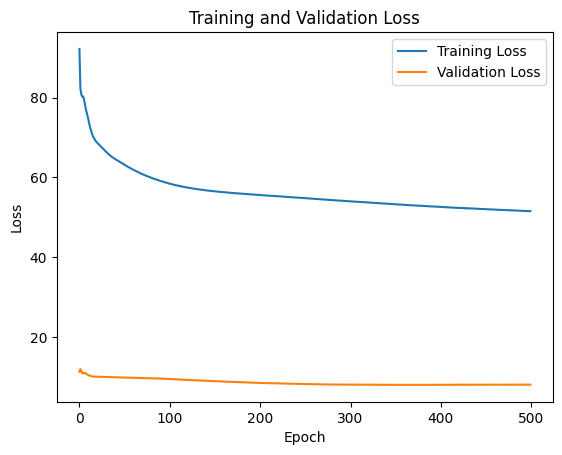

Model saved to models/gcn_1l_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.19GB
Average Memory Usage: 2.74GB

Total Training Time: 4.97s
Max CPU Usage: 4.36GB
Max Memory Usage: 2.78GB


In [29]:
# Create model instances
gcn1_graph = GCN1Layer(num_features, num_classes)
print(gcn1_graph)
print(f"Total number of trainable parameters: {(gcn1_graph.count_parameters())*2}\n")
train_graph(gcn1_graph, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, save_path='models/gcn_1l_graph.pth')

#### GCN 2-Layer

GCN2Layer(
  (gcn1): GCN (7 -> 64)
  (gcn2): GCN (64 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 9604

Epoch 1, Train Loss: 85.11884832382202, Val Loss: 11.641446053981781
Time: 0.02s, CPU: 1.50GB, Memory: 2.74GB
Epoch 2, Train Loss: 79.75125551223755, Val Loss: 10.657007396221161
Time: 0.01s, CPU: 2.46GB, Memory: 2.73GB
Epoch 3, Train Loss: 79.69751924276352, Val Loss: 10.830072462558746
Time: 0.01s, CPU: 1.60GB, Memory: 2.73GB
Epoch 4, Train Loss: 75.29629546403885, Val Loss: 10.34631997346878
Time: 0.01s, CPU: 1.60GB, Memory: 2.73GB
Epoch 5, Train Loss: 72.10650140047073, Val Loss: 9.69507783651352
Time: 0.01s, CPU: 1.46GB, Memory: 2.73GB
Epoch 6, Train Loss: 69.09116792678833, Val Loss: 9.48305457830429
Time: 0.01s, CPU: 3.08GB, Memory: 2.73GB
Epoch 7, Train Loss: 67.16878980398178, Val Loss: 9.35907930135727
Time: 0.01s, CPU: 2.66GB, Memory: 2.73GB
Epoch 8, Train Loss: 66.62325078248978, Val Loss: 9.305270612239838
Time:

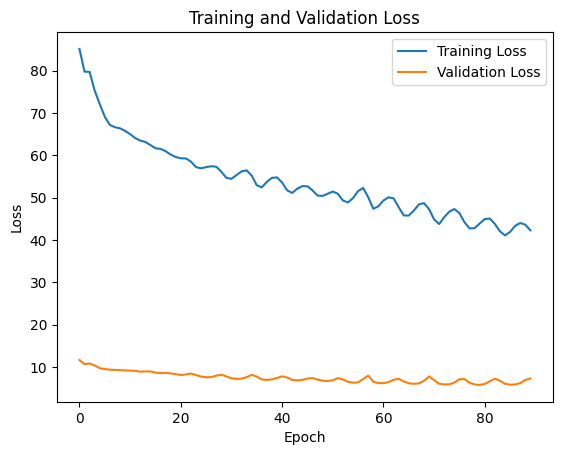

Model saved to models/gcn_2l_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.39GB
Average Memory Usage: 2.74GB

Total Training Time: 1.20s
Max CPU Usage: 3.08GB
Max Memory Usage: 2.74GB


In [30]:
gcn2_graph = GCN2Layer(num_features, num_classes)
print(gcn2_graph)
print(f"Total number of trainable parameters: {(gcn2_graph.count_parameters())*2}\n")
train_graph(gcn2_graph, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, save_path='models/gcn_2l_graph.pth')

### GCESN

#### Variant 1

GCESN_var1(
  (fc): Linear(in_features=7, out_features=2, bias=True)
)
Total number of trainable parameters: 16

Epoch 1, Train Loss: 3852.0627088546753, Val Loss: 204.17698860168457
Time: 0.01s, CPU: 1.25GB, Memory: 2.73GB
Epoch 2, Train Loss: 2179.8715925216675, Val Loss: 78.0152177810669
Time: 0.01s, CPU: 1.46GB, Memory: 2.73GB
Epoch 3, Train Loss: 558.1873762607574, Val Loss: 35.50792336463928
Time: 0.01s, CPU: 2.00GB, Memory: 2.73GB
Epoch 4, Train Loss: 278.7373914718628, Val Loss: 84.2919373512268
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 5, Train Loss: 441.77607250213623, Val Loss: 94.77554082870483
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 6, Train Loss: 446.720356464386, Val Loss: 81.11597299575806
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 7, Train Loss: 351.0539209842682, Val Loss: 51.81840419769287
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 8, Train Loss: 191.27679753303528, Val Loss: 14.989926517009735
Time: 0.01s, CPU: 0.00GB, Memory: 2.73GB
Epoch 9, Tra

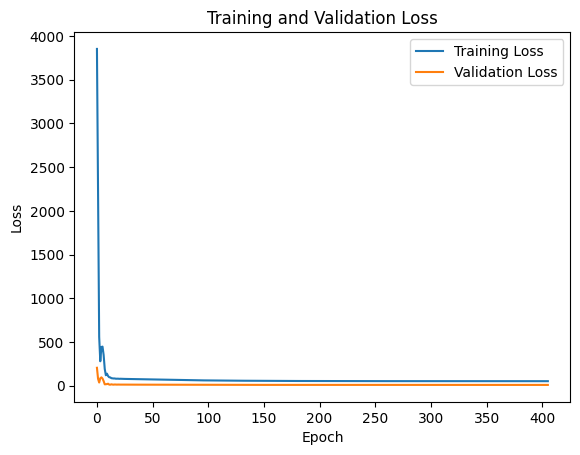

Model saved to models/gcesn_v1_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.14GB
Average Memory Usage: 2.71GB

Total Training Time: 3.83s
Max CPU Usage: 3.08GB
Max Memory Usage: 2.73GB


In [27]:
# Create model instances
gcesn1_graph = GCESN_var1(num_features, num_features, num_classes, num_iterations=6)
print(gcesn1_graph)
print(f"Total number of trainable parameters: {gcesn1_graph.count_parameters()}\n")
train_graph(gcesn1_graph, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, save_path='models/gcesn_v1_graph.pth')

In [69]:
gcesn1_graph = GCESN_var1(num_features, num_features, num_classes, num_iterations=6)
train_and_evaluate_multiple_runs_graph(gcesn1_graph, mutag_train_loader, mutag_val_loader, path='models/multiple_run/gcesn_v1_graph_')

Model saved to models/multiple_run/gcesn_v1_graph__run0.pth

Run 1/50 -> Loss: 49.41692431271076
  Total Training Time: 2.87s, Avg CPU Usage: 0.05GB, Avg Memory Usage: 2.76GB, Max CPU Usage: 6.22GB, Max Memory Usage: 2.76GB
  Accuracy: 0.8947, Sensitivity: 0.9231, Specificity: 0.8333
Early stopping at epoch 10
Model saved to models/multiple_run/gcesn_v1_graph__run1.pth

Run 2/50 -> Loss: 49.428967997431755
  Total Training Time: 0.05s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.75GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.75GB
  Accuracy: 0.8947, Sensitivity: 0.9231, Specificity: 0.8333
Early stopping at epoch 10
Model saved to models/multiple_run/gcesn_v1_graph__run2.pth

Run 3/50 -> Loss: 49.42554162442684
  Total Training Time: 0.05s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.75GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.75GB
  Accuracy: 0.8947, Sensitivity: 0.9231, Specificity: 0.8333
Early stopping at epoch 10
Model saved to models/multiple_run/gcesn_v1_graph__run3.pth

Ru

#### Variant 2

GCESN_var2(
  (fc): Linear(in_features=7, out_features=2, bias=True)
)
Total number of trainable parameters: 16

Epoch 1, Train Loss: 5172.40106010437, Val Loss: 274.45587158203125
Time: 0.01s, CPU: 0.98GB, Memory: 2.76GB
Epoch 2, Train Loss: 2923.962410926819, Val Loss: 104.51897621154785
Time: 0.01s, CPU: 4.00GB, Memory: 2.77GB
Epoch 3, Train Loss: 733.4981346130371, Val Loss: 48.63921403884888
Time: 0.01s, CPU: 3.00GB, Memory: 2.77GB
Epoch 4, Train Loss: 385.3057818412781, Val Loss: 114.62782859802246
Time: 0.01s, CPU: 3.43GB, Memory: 2.77GB
Epoch 5, Train Loss: 605.157883644104, Val Loss: 127.19233989715576
Time: 0.01s, CPU: 2.29GB, Memory: 2.77GB
Epoch 6, Train Loss: 602.1519050598145, Val Loss: 106.25204801559448
Time: 0.01s, CPU: 0.00GB, Memory: 2.77GB
Epoch 7, Train Loss: 457.75565004348755, Val Loss: 63.60618352890015
Time: 0.01s, CPU: 0.00GB, Memory: 2.77GB
Epoch 8, Train Loss: 222.3627039194107, Val Loss: 12.251977622509003
Time: 0.01s, CPU: 0.00GB, Memory: 2.77GB
Epoch 9, T

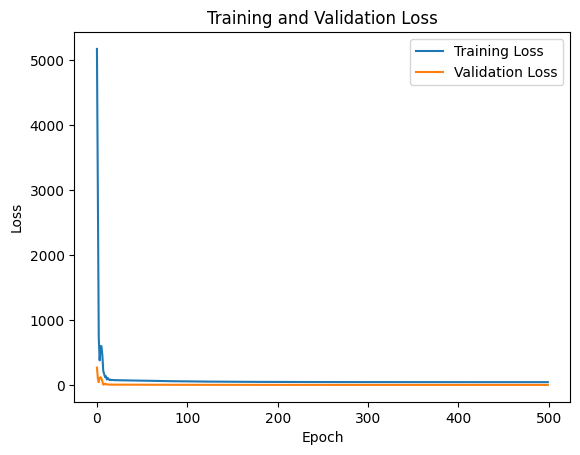

Model saved to models/gcesn_v2_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.11GB
Average Memory Usage: 2.76GB

Total Training Time: 3.08s
Max CPU Usage: 5.34GB
Max Memory Usage: 2.77GB


In [78]:
# Create model instances
gcesn2_graph = GCESN_var2(num_features, num_features, num_classes, num_iterations=6)
print(gcesn2_graph)
print(f"Total number of trainable parameters: {gcesn2_graph.count_parameters()}\n")
train_graph(gcesn2_graph, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, save_path='models/gcesn_v2_graph.pth')

In [72]:
gcesn2_graph = GCESN_var2(num_features, num_features, num_classes, num_iterations=6)
train_and_evaluate_multiple_runs_graph(gcesn2_graph, mutag_train_loader, mutag_val_loader, path='models/multiple_run/gcesn_v2_graph_')

Model saved to models/multiple_run/gcesn_v2_graph__run0.pth

Run 1/50 -> Loss: 59.12661898136139
  Total Training Time: 3.03s, Avg CPU Usage: 0.14GB, Avg Memory Usage: 2.79GB, Max CPU Usage: 8.00GB, Max Memory Usage: 2.80GB
  Accuracy: 0.7895, Sensitivity: 0.9615, Specificity: 0.4167
Early stopping at epoch 11
Model saved to models/multiple_run/gcesn_v2_graph__run1.pth

Run 2/50 -> Loss: 59.03563851118088
  Total Training Time: 0.07s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.78GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.78GB
  Accuracy: 0.7632, Sensitivity: 0.9231, Specificity: 0.4167
Early stopping at epoch 11
Model saved to models/multiple_run/gcesn_v2_graph__run2.pth

Run 3/50 -> Loss: 58.999292731285095
  Total Training Time: 0.07s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.78GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.78GB
  Accuracy: 0.7632, Sensitivity: 0.9231, Specificity: 0.4167
Early stopping at epoch 11
Model saved to models/multiple_run/gcesn_v2_graph__run3.pth

Ru

### GCN-ESN

#### Variant 1

GCNESN_var1(
  (gcn1): GCN (7 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 642

Epoch 1, Train Loss: 85.6922373175621, Val Loss: 10.534148812294006
Time: 0.01s, CPU: 1.09GB, Memory: 2.76GB
Epoch 2, Train Loss: 83.47108399868011, Val Loss: 10.427325367927551
Time: 0.01s, CPU: 4.30GB, Memory: 2.76GB
Epoch 3, Train Loss: 78.97764873504639, Val Loss: 11.035561859607697
Time: 0.01s, CPU: 4.80GB, Memory: 2.76GB
Epoch 4, Train Loss: 75.0333241224289, Val Loss: 9.790491163730621
Time: 0.01s, CPU: 4.36GB, Memory: 2.76GB
Epoch 5, Train Loss: 74.93561285734177, Val Loss: 10.23613303899765
Time: 0.01s, CPU: 0.00GB, Memory: 2.76GB
Epoch 6, Train Loss: 71.79861497879028, Val Loss: 9.877511858940125
Time: 0.01s, CPU: 0.00GB, Memory: 2.76GB
Epoch 7, Train Loss: 71.50680333375931, Val Loss: 10.022903680801392
Time: 0.01s, CPU: 0.00GB, Memory: 2.76GB
Epoch 8, Train Loss: 70.3406308889389, Val Loss: 10.054178237915039
Time: 0.01s, CPU: 0.00GB, M

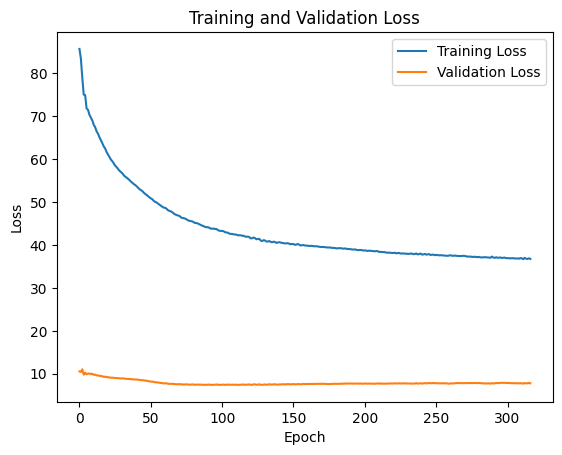

Model saved to models/gcnesn_v1_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.19GB
Average Memory Usage: 2.76GB

Total Training Time: 2.17s
Max CPU Usage: 4.80GB
Max Memory Usage: 2.76GB


In [53]:
# Create model instances
gcnesn1_graph = GCNESN_var1(num_features, 64, num_classes)
print(gcnesn1_graph)
print(f"Total number of trainable parameters: {gcnesn1_graph.count_parameters()}\n")
train_graph(gcnesn1_graph, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, save_path='models/gcnesn_v1_graph.pth')

In [73]:
# Create model instances
gcnesn1_graph = GCNESN_var1(num_features, 64, num_classes)
train_and_evaluate_multiple_runs_graph(gcnesn1_graph, mutag_train_loader, mutag_val_loader, path='models/multiple_run/gcnesn_v1_graph_')

Early stopping at epoch 120
Model saved to models/multiple_run/gcnesn_v1_graph__run0.pth

Run 1/50 -> Loss: 40.02058753371239
  Total Training Time: 0.80s, Avg CPU Usage: 0.08GB, Avg Memory Usage: 2.82GB, Max CPU Usage: 2.66GB, Max Memory Usage: 2.82GB
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167
Early stopping at epoch 15
Model saved to models/multiple_run/gcnesn_v1_graph__run1.pth

Run 2/50 -> Loss: 38.0583802908659
  Total Training Time: 0.15s, Avg CPU Usage: 0.86GB, Avg Memory Usage: 2.82GB, Max CPU Usage: 7.32GB, Max Memory Usage: 2.84GB
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167
Early stopping at epoch 15
Model saved to models/multiple_run/gcnesn_v1_graph__run2.pth

Run 3/50 -> Loss: 38.0394793599844
  Total Training Time: 0.10s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.82GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.82GB
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167
Early stopping at epoch 15
Model saved to models/multiple_run/

#### Variant 2

GCNESN_var2(
  (gcn1): GCN (7 -> 64)
  (gcn2): GCN (64 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 4802

Epoch 1, Train Loss: 88.76826161146164, Val Loss: 9.960194528102875
Time: 0.02s, CPU: 1.29GB, Memory: 2.82GB
Epoch 2, Train Loss: 86.95001989603043, Val Loss: 12.010091543197632
Time: 0.01s, CPU: 2.66GB, Memory: 2.81GB
Epoch 3, Train Loss: 74.99515354633331, Val Loss: 10.237768292427063
Time: 0.02s, CPU: 4.36GB, Memory: 2.79GB
Epoch 4, Train Loss: 73.28107434511185, Val Loss: 9.712825119495392
Time: 0.01s, CPU: 1.78GB, Memory: 2.79GB
Epoch 5, Train Loss: 69.55853348970413, Val Loss: 9.948712885379791
Time: 0.01s, CPU: 2.66GB, Memory: 2.80GB
Epoch 6, Train Loss: 67.12131994962692, Val Loss: 9.571468234062195
Time: 0.01s, CPU: 1.14GB, Memory: 2.80GB
Epoch 7, Train Loss: 67.4722228050232, Val Loss: 9.536522626876831
Time: 0.01s, CPU: 1.00GB, Memory: 2.80GB
Epoch 8, Train Loss: 66.37564092874527, Val Loss: 9.315887689590454
Ti

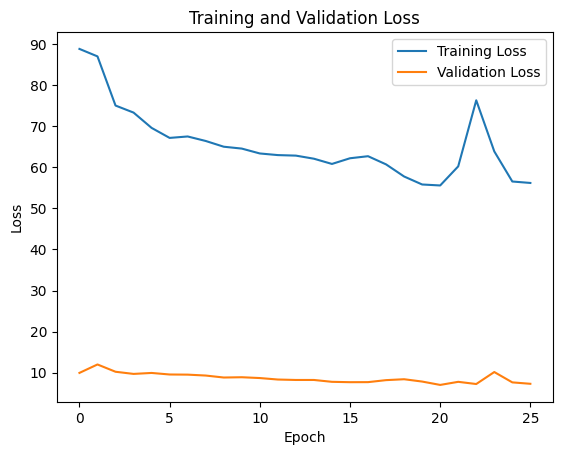

Model saved to models/gcnesn_v2_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.68GB
Average Memory Usage: 2.80GB

Total Training Time: 0.25s
Max CPU Usage: 4.36GB
Max Memory Usage: 2.82GB


In [60]:
# Create model instances
gcnesn2_graph = GCNESN_var2(num_features, 64, num_classes)
print(gcnesn2_graph)
print(f"Total number of trainable parameters: {gcnesn2_graph.count_parameters()}\n")
train_graph(gcnesn2_graph, mutag_train_loader, mutag_val_loader, lr=0.01, num_epochs=500, save_path='models/gcnesn_v2_graph.pth')

In [74]:
# Create model instances
gcnesn2_graph = GCNESN_var2(num_features, 64, num_classes)
train_and_evaluate_multiple_runs_graph(gcnesn2_graph, mutag_train_loader, mutag_val_loader, path='models/multiple_run/gcnesn_v2_graph_')

Early stopping at epoch 56
Model saved to models/multiple_run/gcnesn_v2_graph__run0.pth

Run 1/50 -> Loss: 46.970199793577194
  Total Training Time: 0.48s, Avg CPU Usage: 0.20GB, Avg Memory Usage: 2.78GB, Max CPU Usage: 2.91GB, Max Memory Usage: 2.78GB
  Accuracy: 0.9211, Sensitivity: 0.8846, Specificity: 1.0000
Early stopping at epoch 36
Model saved to models/multiple_run/gcnesn_v2_graph__run1.pth

Run 2/50 -> Loss: 41.03866462409496
  Total Training Time: 0.29s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.77GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.78GB
  Accuracy: 0.8947, Sensitivity: 0.8846, Specificity: 0.9167
Early stopping at epoch 33
Model saved to models/multiple_run/gcnesn_v2_graph__run2.pth

Run 3/50 -> Loss: 38.12930679321289
  Total Training Time: 0.27s, Avg CPU Usage: 0.11GB, Avg Memory Usage: 2.76GB, Max CPU Usage: 2.14GB, Max Memory Usage: 2.76GB
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167
Early stopping at epoch 39
Model saved to models/multiple_ru

## Evaluation

In [79]:
print('Model 1-Layer GCN')
gcn1_graph = GCN1Layer(num_features, num_classes)
gcn1_graph.load_state_dict(torch.load('models/gcn_1l_graph.pth'))
test_graph(gcn1_graph, mutag_test_loader)

print('\nModel 2-Layer GCN')
gcn2_graph = GCN2Layer(num_features, num_classes)
gcn2_graph.load_state_dict(torch.load('models/gcn_2l_graph.pth'))
test_graph(gcn2_graph, mutag_test_loader)

print('\nModel GCESN Var-1')
gcesn1_graph = GCESN_var1(num_features, num_features, num_classes, num_iterations=6)
gcesn1_graph.load_state_dict(torch.load('models/gcesn_v1_graph.pth'))
test_graph(gcesn1_graph, mutag_test_loader)

print('\nModel GCESN Var-2')
gcesn2_graph = GCESN_var2(num_features, num_features, num_classes, num_iterations=6)
gcesn2_graph.load_state_dict(torch.load('models/gcesn_v2_graph.pth'))
test_graph(gcesn2_graph, mutag_test_loader)

print('\nModel GCNESN Var-1')
gcnesn1_graph = GCNESN_var1(num_features, 64, num_classes)
gcnesn1_graph.load_state_dict(torch.load('models/gcnesn_v1_graph.pth'))
test_graph(gcnesn1_graph, mutag_test_loader)

print('\nModel GCNESN Var-2')
gcnesn2_graph = GCNESN_var2(num_features, 64, num_classes)
gcnesn2_graph.load_state_dict(torch.load('models/gcnesn_v2_graph.pth'))
test_graph(gcnesn2_graph, mutag_test_loader)

Model 1-Layer GCN
Accuracy: 0.9211
Sensitivity: 0.9231
Specificity: 0.9167

Model 2-Layer GCN
Accuracy: 0.8947
Sensitivity: 0.8846
Specificity: 0.9167

Model GCESN Var-1
Accuracy: 0.8158
Sensitivity: 0.8846
Specificity: 0.6667

Model GCESN Var-2
Accuracy: 0.8684
Sensitivity: 0.8846
Specificity: 0.8333

Model GCNESN Var-1
Accuracy: 0.9474
Sensitivity: 0.9615
Specificity: 0.9167

Model GCNESN Var-2
Accuracy: 0.9211
Sensitivity: 0.8846
Specificity: 1.0000


In [80]:
def measure_inference_performance(model, loader):
    model.eval()
    inference_times = []
    cpu_usages = []
    memory_usages = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)

            start_time = time.time()
            cpu_start = psutil.cpu_percent(interval=None)
            mem_start = psutil.virtual_memory().used

            output = model(x, adj_matrix, batch)

            cpu_end = psutil.cpu_percent(interval=None)
            mem_end = psutil.virtual_memory().used
            end_time = time.time()

            inference_times.append(end_time - start_time)
            cpu_usages.append((cpu_end - cpu_start) / 100 * psutil.virtual_memory().total / (1024**2))
            memory_usages.append((mem_end - mem_start) / (1024**2))

    avg_inference_time = np.mean(inference_times)
    avg_cpu_usage = np.mean(cpu_usages)
    avg_memory_usage = np.mean(memory_usages)

    print(f'Average Inference Time: {avg_inference_time:.6f}s')
    print(f'Average CPU Usage: {avg_cpu_usage:.6f}MB')
    print(f'Average Memory Usage: {avg_memory_usage:.6f}MB')

    return
    # return avg_inference_time, avg_cpu_usage, avg_memory_usage

In [81]:
print('\nInference 1-Layer GCN:')
measure_inference_performance(gcn1_graph, mutag_test_loader)

print('\nInference 2-Layer GCN:')
measure_inference_performance(gcn2_graph, mutag_test_loader)

print('\nInference GCESN Var-1:')
measure_inference_performance(gcesn1_graph, mutag_test_loader)

print('\nInference GCESN Var-2:')
measure_inference_performance(gcesn2_graph, mutag_test_loader)

print('\nInference GCNESN Var-1:')
measure_inference_performance(gcnesn1_graph, mutag_test_loader)

print('\nInference GCNESN Var-2:')
measure_inference_performance(gcnesn2_graph, mutag_test_loader)


Inference 1-Layer GCN:
Average Inference Time: 0.000768s
Average CPU Usage: -516.096000MB
Average Memory Usage: 0.132812MB

Inference 2-Layer GCN:
Average Inference Time: 0.000459s
Average CPU Usage: -4096.000000MB
Average Memory Usage: 0.000000MB

Inference GCESN Var-1:
Average Inference Time: 0.000528s
Average CPU Usage: 0.000000MB
Average Memory Usage: 0.000000MB

Inference GCESN Var-2:
Average Inference Time: 0.000672s
Average CPU Usage: 0.000000MB
Average Memory Usage: 0.000000MB

Inference GCNESN Var-1:
Average Inference Time: 0.000401s
Average CPU Usage: 0.000000MB
Average Memory Usage: 0.000000MB

Inference GCNESN Var-2:
Average Inference Time: 0.000675s
Average CPU Usage: 0.000000MB
Average Memory Usage: 0.000000MB


# Node Classification

In [83]:
# Load the Cora dataset
cora_dataset = Planetoid(root='/tmp/Cora', name='Cora')
cora_data = cora_dataset[0]

# Example of data attributes
print(cora_data)
print("Node feature shape:", cora_data.x.shape)
print("Edge index shape:", cora_data.edge_index.shape)
print("Number of classes:", cora_dataset.num_classes)
print("Number of node features:", cora_dataset.num_node_features)

# Splitting the data into train, validation, and test sets
train_mask = cora_data.train_mask
val_mask = cora_data.val_mask
test_mask = cora_data.test_mask


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Node feature shape: torch.Size([2708, 1433])
Edge index shape: torch.Size([2, 10556])
Number of classes: 7
Number of node features: 1433


In [84]:
longest_path, shortest_path, overall_average_path, std_average_path = compute_path_lengths(cora_data)
print(f'Cora dataset - Longest path: {longest_path}')
print(f'Cora dataset - Shortest path: {shortest_path}')
print(f'Cora dataset - Overall average path: {overall_average_path:.2f}')
print(f'Cora dataset - Standard deviation of average paths: {std_average_path:.2f}')

Cora dataset - Longest path: 19
Cora dataset - Shortest path: 0
Cora dataset - Overall average path: 6.31
Cora dataset - Standard deviation of average paths: 0.00


## Model Definition

### Models

#### GCN

In [85]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, adj):
        # print(f'x shape: {x.shape}, adj shape: {adj.shape}')
        x = F.relu(self.gcn1(x, adj))
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, 16)
        self.gcn2 = GCN(16, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, adj):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### GCESN

In [86]:
class GCESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=6):
        super(GCESN_var1, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(adj, torch.mm(h, self.W)))
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=6):
        super(GCESN_var2, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(x, self.W) + torch.mm(adj, torch.mm(h, self.W)))
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### GCN-ESN

In [87]:
class GCNESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var1, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj):
        n_node, _ = x.shape 
        state = torch.zeros(n_node, self.hidden_features)
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))

        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCNESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var2, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj):
        n_node, _ = x.shape 
        state = torch.zeros(n_node, self.hidden_features)
        
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        x = F.relu(self.gcn2(state, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Utilities

In [113]:
def train_node(model, data, lr=0.001, num_epochs=100, patience=10, save_path='models/gcn_x.pth'):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    adj_matrix = utils.to_dense_adj(data.edge_index).squeeze(0)  # Convert edge_index to adjacency matrix

    for epoch in range(num_epochs):
        epoch_loss = 0
        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        optimizer.zero_grad()
        output = model(data.x, adj_matrix)
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        epoch_loss = loss.item()

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            val_output = model(data.x, adj_matrix)
            val_loss = criterion(val_output[data.val_mask], data.y[data.val_mask]).item()

        validation_loss.append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch {epoch + 1}, Train Loss: {epoch_loss}, Val Loss: {val_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')

    # Plot the training and validation loss
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Load the best model
    model.load_state_dict(torch.load(save_path))
    print(f'Model saved to {save_path}')

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage = np.mean(cpu_usage)
    avg_memory_usage = np.mean(memory_usage)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage = np.max(cpu_usage)
    max_memory_usage = np.max(memory_usage)

    print(f'Average Time per Epoch: {avg_epoch_time:.2f}s')
    print(f'Average CPU Usage: {avg_cpu_usage:.2f}GB')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')

    print(f'\nTotal Training Time: {total_training_time:.2f}s')
    print(f'Max CPU Usage: {max_cpu_usage:.2f}GB')
    print(f'Max Memory Usage: {max_memory_usage:.2f}GB')

    return
    # return training_loss[-1], total_training_time, avg_cpu_usage, avg_memory_usage, max_cpu_usage, max_memory_usage 

def evaluate(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    
    return accuracy, sensitivity, specificity

def test_node(model, data, mask):
    model.eval()
    y_true = data.y[mask].tolist()
    y_pred = []

    with torch.no_grad():
        adj_matrix = utils.to_dense_adj(data.edge_index).squeeze(0)
        output = model(data.x, adj_matrix)
        pred = output[mask].argmax(dim=1)
        y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate(y_true, y_pred)
    return 
    # return accuracy, sensitivity, specificity

In [107]:
def train_and_evaluate_multiple_runs_node(model, data, num_runs=50, num_epochs=100, path='models/multiple_run/gcesn_v1_node_'):
    all_accuracies = []
    all_sensitivities = []
    all_specificities = []
    all_training_times = []
    all_avg_cpu_usages = []
    all_avg_memory_usages = []
    all_max_cpu_usages = []
    all_max_memory_usages = []

    for run in range(num_runs):
        # Train the model
        save_path = path + f'_run{run}.pth'
        loss, training_time, avg_cpu, avg_memory, max_cpu, max_memory = train_node(model, data, lr=0.01, num_epochs=num_epochs, save_path=save_path)
        
        # Test the model
        accuracy, sensitivity, specificity = test_node(model, cora_data, cora_data.test_mask)

        # Store results
        all_accuracies.append(accuracy)
        all_sensitivities.append(sensitivity)
        all_specificities.append(specificity)
        all_training_times.append(training_time)
        all_avg_cpu_usages.append(avg_cpu)
        all_avg_memory_usages.append(avg_memory)
        all_max_cpu_usages.append(max_cpu)
        all_max_memory_usages.append(max_memory)

        print(f'\nRun {run+1}/{num_runs} -> Loss: {loss}')
        print(f'  Total Training Time: {training_time:.2f}s, Avg CPU Usage: {avg_cpu:.2f}GB, Avg Memory Usage: {avg_memory:.2f}GB, Max CPU Usage: {max_cpu:.2f}GB, Max Memory Usage: {max_memory:.2f}GB')
        print(f'  Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')

    # Compute average values across all runs
    avg_accuracy = np.mean(all_accuracies)
    avg_sensitivity = np.mean(all_sensitivities)
    avg_specificity = np.mean(all_specificities)
    avg_training_time = np.mean(all_training_times)
    avg_cpu_usage = np.mean(all_avg_cpu_usages)
    avg_memory_usage = np.mean(all_avg_memory_usages)
    avg_max_cpu_usage = np.mean(all_max_cpu_usages)
    avg_max_memory_usage = np.mean(all_max_memory_usages)

    print('Overall Results:')
    print(f'  Avg Accuracy: {avg_accuracy:.4f}, Avg Sensitivity: {avg_sensitivity:.4f}, Avg Specificity: {avg_specificity:.4f}')
    print(f'  Avg Training Time: {avg_training_time:.2f}s, Avg CPU Usage: {avg_cpu_usage:.2f}GB, Avg Memory Usage: {avg_memory_usage:.2f}GB, Avg Max CPU Usage: {avg_max_cpu_usage:.2f}GB, Avg Max Memory Usage: {avg_max_memory_usage:.2f}GB')

## Training

### GCN

GCN1Layer(
  (gcn1): GCN (1433 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23063

Epoch 1, Train Loss: 2.170762777328491, Val Loss: 1.900010585784912
Time: 0.04s, CPU: 1.10GB, Memory: 2.86GB
Epoch 2, Train Loss: 1.741358757019043, Val Loss: 1.842060923576355
Time: 0.01s, CPU: 2.18GB, Memory: 2.86GB
Epoch 3, Train Loss: 1.5352405309677124, Val Loss: 1.7968140840530396
Time: 0.01s, CPU: 3.00GB, Memory: 2.86GB
Epoch 4, Train Loss: 1.3967152833938599, Val Loss: 1.752159833908081
Time: 0.01s, CPU: 2.66GB, Memory: 2.86GB
Epoch 5, Train Loss: 1.2808040380477905, Val Loss: 1.6996108293533325
Time: 0.01s, CPU: 3.20GB, Memory: 2.86GB
Epoch 6, Train Loss: 1.1763676404953003, Val Loss: 1.6426030397415161
Time: 0.01s, CPU: 2.66GB, Memory: 2.86GB
Epoch 7, Train Loss: 1.0777981281280518, Val Loss: 1.5830470323562622
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 8, Train Loss: 0.9860337376594543, Val Loss: 1.5247200727462769
Time: 0.01s, CP

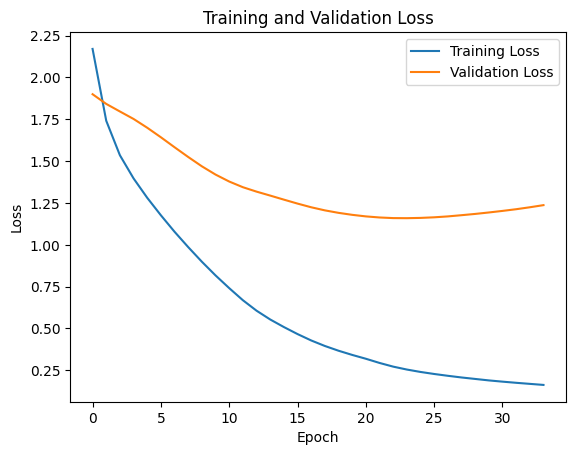

Model saved to models/gcn_1l_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.59GB
Average Memory Usage: 2.86GB

Total Training Time: 0.28s
Max CPU Usage: 3.55GB
Max Memory Usage: 2.86GB


In [92]:
# Create model instances
gcn1_node = GCN1Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
print(gcn1_node)
print(f"Total number of trainable parameters: {gcn1_node.count_parameters()}\n")
train_node(gcn1_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcn_1l_node.pth')


GCN2Layer(
  (gcn1): GCN (1433 -> 16)
  (gcn2): GCN (16 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23335

Epoch 1, Train Loss: 3.7939679622650146, Val Loss: 1.9179457426071167
Time: 0.02s, CPU: 1.01GB, Memory: 2.84GB
Epoch 2, Train Loss: 2.5998010635375977, Val Loss: 1.911553978919983
Time: 0.01s, CPU: 0.73GB, Memory: 2.84GB
Epoch 3, Train Loss: 2.189985513687134, Val Loss: 1.8619734048843384
Time: 0.01s, CPU: 4.40GB, Memory: 2.84GB
Epoch 4, Train Loss: 1.964756965637207, Val Loss: 1.826151728630066
Time: 0.01s, CPU: 4.00GB, Memory: 2.84GB
Epoch 5, Train Loss: 1.7606745958328247, Val Loss: 1.789262056350708
Time: 0.01s, CPU: 0.00GB, Memory: 2.84GB
Epoch 6, Train Loss: 1.6393909454345703, Val Loss: 1.7657700777053833
Time: 0.01s, CPU: 0.00GB, Memory: 2.84GB
Epoch 7, Train Loss: 1.5808825492858887, Val Loss: 1.7448158264160156
Time: 0.01s, CPU: 0.00GB, Memory: 2.84GB
Epoch 8, Train Loss: 1.5417717695236206, Val Loss: 1.7129913

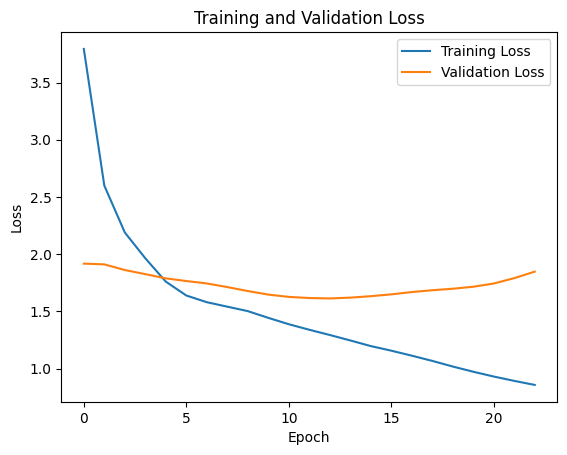

Model saved to models/gcn_2l_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.44GB
Average Memory Usage: 2.84GB

Total Training Time: 0.28s
Max CPU Usage: 4.40GB
Max Memory Usage: 2.84GB


In [93]:
gcn2_node = GCN2Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
print(gcn2_node)
print(f"Total number of trainable parameters: {gcn2_node.count_parameters()}\n")
train_node(gcn2_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcn_2l_node.pth')

### GCESN

#### Variant 1

GCESN_var1(
  (fc): Linear(in_features=1433, out_features=7, bias=True)
)
Total number of trainable parameters: 10038

Epoch 1, Train Loss: 4.440561771392822, Val Loss: 4.74982213973999
Time: 0.11s, CPU: 0.94GB, Memory: 2.86GB
Epoch 2, Train Loss: 5.486979961395264, Val Loss: 16.247295379638672
Time: 0.10s, CPU: 2.05GB, Memory: 2.83GB
Epoch 3, Train Loss: 13.739534378051758, Val Loss: 20.38908576965332
Time: 0.10s, CPU: 1.90GB, Memory: 2.83GB
Epoch 4, Train Loss: 16.88147735595703, Val Loss: 20.84930419921875
Time: 0.10s, CPU: 2.02GB, Memory: 2.87GB
Epoch 5, Train Loss: 18.30681610107422, Val Loss: 17.689401626586914
Time: 0.10s, CPU: 1.86GB, Memory: 2.86GB
Epoch 6, Train Loss: 16.426950454711914, Val Loss: 13.21545696258545
Time: 0.10s, CPU: 1.93GB, Memory: 2.86GB
Epoch 7, Train Loss: 13.537982940673828, Val Loss: 10.217391014099121
Time: 0.10s, CPU: 1.74GB, Memory: 2.86GB
Epoch 8, Train Loss: 11.303751945495605, Val Loss: 10.406953811645508
Time: 0.10s, CPU: 1.94GB, Memory: 2.86GB
Ep

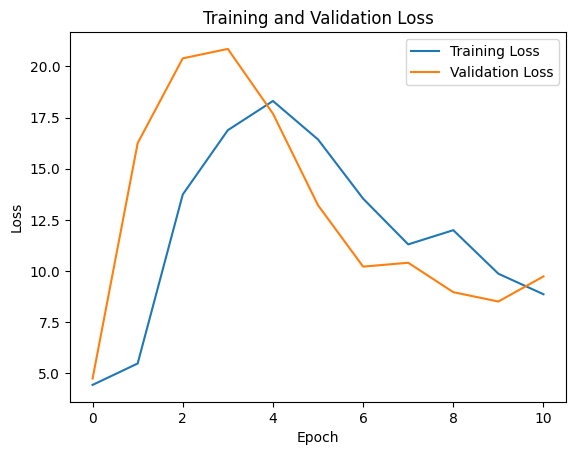

Model saved to models/gcesn_v1_node.pth
Average Time per Epoch: 0.10s
Average CPU Usage: 1.90GB
Average Memory Usage: 2.85GB

Total Training Time: 1.15s
Max CPU Usage: 2.39GB
Max Memory Usage: 2.87GB


In [94]:
# Create model instances
num_features = cora_dataset.num_node_features
gcesn1_node = GCESN_var1(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
print(gcesn1_node)
print(f"Total number of trainable parameters: {gcesn1_node.count_parameters()}\n")
train_node(gcesn1_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcesn_v1_node.pth')

In [108]:
num_features = cora_dataset.num_node_features
gcesn1_node = GCESN_var1(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
train_and_evaluate_multiple_runs_node(gcesn1_node, cora_data, path='models/multiple_run/gcesn_v1_node.pth')

Early stopping at epoch 36

Run 1/50 -> Loss: 1.0525579452514648
  Total Training Time: 3.84s, Avg CPU Usage: 1.50GB, Avg Memory Usage: 2.82GB, Max CPU Usage: 3.54GB, Max Memory Usage: 2.86GB
  Accuracy: 0.9713, Sensitivity: 0.9726, Specificity: 0.9703
Early stopping at epoch 17

Run 2/50 -> Loss: 1.1124626398086548
  Total Training Time: 1.84s, Avg CPU Usage: 1.80GB, Avg Memory Usage: 2.80GB, Max CPU Usage: 3.39GB, Max Memory Usage: 2.83GB
  Accuracy: 0.9540, Sensitivity: 0.9077, Specificity: 0.9817
Early stopping at epoch 18

Run 3/50 -> Loss: 0.7828157544136047
  Total Training Time: 1.90s, Avg CPU Usage: 1.55GB, Avg Memory Usage: 2.79GB, Max CPU Usage: 3.17GB, Max Memory Usage: 2.82GB
  Accuracy: 0.9786, Sensitivity: 0.9853, Specificity: 0.9722
Early stopping at epoch 15

Run 4/50 -> Loss: 0.78678959608078
  Total Training Time: 1.56s, Avg CPU Usage: 1.64GB, Avg Memory Usage: 2.78GB, Max CPU Usage: 2.42GB, Max Memory Usage: 2.81GB
  Accuracy: 0.9565, Sensitivity: 0.9861, Specificit

#### variant 2

GCESN_var2(
  (fc): Linear(in_features=1433, out_features=7, bias=True)
)
Total number of trainable parameters: 10038

Epoch 1, Train Loss: 0.0013442391064018011, Val Loss: 14.414905548095703
Time: 0.23s, CPU: 1.37GB, Memory: 2.91GB
Epoch 2, Train Loss: 2.6263698600814678e-05, Val Loss: 16.510513305664062
Time: 0.15s, CPU: 1.89GB, Memory: 2.90GB
Epoch 3, Train Loss: 0.4095669686794281, Val Loss: 16.189125061035156
Time: 0.15s, CPU: 2.38GB, Memory: 2.90GB
Epoch 4, Train Loss: 0.0007609712774865329, Val Loss: 16.734525680541992
Time: 0.15s, CPU: 1.90GB, Memory: 2.90GB
Epoch 5, Train Loss: 0.025418085977435112, Val Loss: 16.269323348999023
Time: 0.15s, CPU: 1.78GB, Memory: 2.89GB
Epoch 6, Train Loss: 0.09912899881601334, Val Loss: 15.781646728515625
Time: 0.15s, CPU: 2.41GB, Memory: 2.90GB
Epoch 7, Train Loss: 0.008311319164931774, Val Loss: 15.182210922241211
Time: 0.15s, CPU: 2.45GB, Memory: 2.91GB
Epoch 8, Train Loss: 0.07687632739543915, Val Loss: 14.10207748413086
Time: 0.15s, CPU: 0

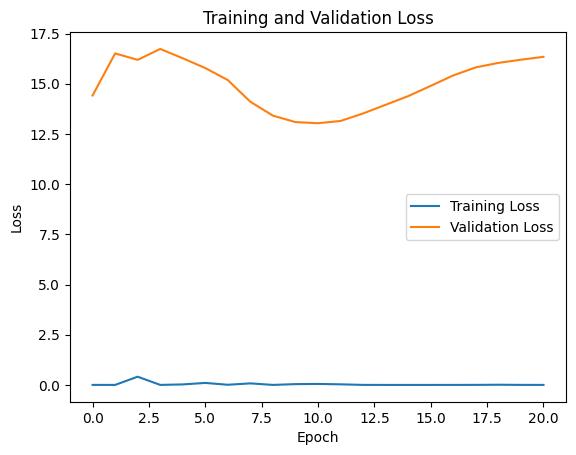

Model saved to models/gcesn_v2_node.pth
Average Time per Epoch: 0.16s
Average CPU Usage: 2.44GB
Average Memory Usage: 2.84GB

Total Training Time: 3.30s
Max CPU Usage: 3.38GB
Max Memory Usage: 2.91GB


In [114]:
# Create model instances
num_features = cora_dataset.num_node_features
gcesn2_node = GCESN_var2(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
print(gcesn2_node)
print(f"Total number of trainable parameters: {gcesn2_node.count_parameters()}\n")
train_node(gcesn1_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcesn_v2_node.pth')

In [110]:
num_features = cora_dataset.num_node_features
gcesn2_node = GCESN_var2(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
train_and_evaluate_multiple_runs_node(gcesn2_node, cora_data, path='models/multiple_run/gcesn_v2_node.pth')

Early stopping at epoch 62

Run 1/50 -> Loss: 0.34658631682395935
  Total Training Time: 8.43s, Avg CPU Usage: 1.90GB, Avg Memory Usage: 2.78GB, Max CPU Usage: 3.41GB, Max Memory Usage: 2.80GB
  Accuracy: 0.9722, Sensitivity: 0.9730, Specificity: 0.9717
Early stopping at epoch 25

Run 2/50 -> Loss: 0.4053628146648407
  Total Training Time: 3.39s, Avg CPU Usage: 2.02GB, Avg Memory Usage: 2.77GB, Max CPU Usage: 3.13GB, Max Memory Usage: 2.80GB
  Accuracy: 0.9648, Sensitivity: 0.9861, Specificity: 0.9429
Early stopping at epoch 17

Run 3/50 -> Loss: 0.5707607269287109
  Total Training Time: 2.32s, Avg CPU Usage: 1.83GB, Avg Memory Usage: 2.76GB, Max CPU Usage: 2.93GB, Max Memory Usage: 2.77GB
  Accuracy: 0.9621, Sensitivity: 0.9857, Specificity: 0.9355
Early stopping at epoch 12

Run 4/50 -> Loss: 1.8224411010742188
  Total Training Time: 1.60s, Avg CPU Usage: 1.83GB, Avg Memory Usage: 2.77GB, Max CPU Usage: 1.98GB, Max Memory Usage: 2.79GB
  Accuracy: 0.9677, Sensitivity: 0.9718, Specifi

### GCN-ESN

#### Variant 1

GCNESN_var1(
  (gcn1): GCN (1433 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23063

Epoch 1, Train Loss: 2.1662473678588867, Val Loss: 1.9906768798828125
Time: 0.01s, CPU: 1.00GB, Memory: 2.86GB
Epoch 2, Train Loss: 1.8308634757995605, Val Loss: 1.8946229219436646
Time: 0.01s, CPU: 4.00GB, Memory: 2.86GB
Epoch 3, Train Loss: 1.6045830249786377, Val Loss: 1.811041235923767
Time: 0.01s, CPU: 2.40GB, Memory: 2.86GB
Epoch 4, Train Loss: 1.4235625267028809, Val Loss: 1.7302359342575073
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 5, Train Loss: 1.258113145828247, Val Loss: 1.6487070322036743
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 6, Train Loss: 1.0968700647354126, Val Loss: 1.562949299812317
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 7, Train Loss: 0.9460855722427368, Val Loss: 1.4765222072601318
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 8, Train Loss: 0.8081862330436707, Val Loss: 1.3926759958267212
Time: 0.01s

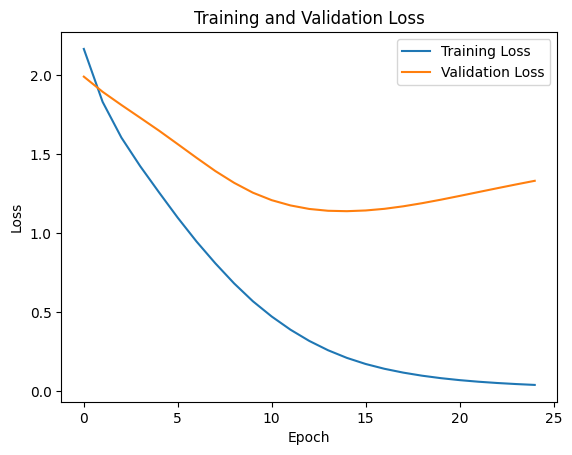

Model saved to models/gcnesn_v1_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.30GB
Average Memory Usage: 2.86GB

Total Training Time: 0.19s
Max CPU Usage: 4.00GB
Max Memory Usage: 2.86GB


In [97]:
# Create model instances
num_features = cora_dataset.num_node_features
gcnesn1_node = GCNESN_var1(num_features, 16, cora_dataset.num_classes)
print(gcnesn1_node)
print(f"Total number of trainable parameters: {gcnesn1_node.count_parameters()}\n")
train_node(gcnesn1_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcnesn_v1_node.pth')

In [111]:
num_features = cora_dataset.num_node_features
gcnesn1_node = GCNESN_var1(num_features, 16, cora_dataset.num_classes)
train_and_evaluate_multiple_runs_node(gcnesn1_node, cora_data, path='models/multiple_run/gcnesn_v1_node.pth')

Early stopping at epoch 25

Run 1/50 -> Loss: 0.037888381630182266
  Total Training Time: 0.25s, Avg CPU Usage: 0.60GB, Avg Memory Usage: 2.94GB, Max CPU Usage: 4.70GB, Max Memory Usage: 2.94GB
  Accuracy: 0.9267, Sensitivity: 0.8871, Specificity: 0.9545
Early stopping at epoch 11

Run 2/50 -> Loss: 0.015521641820669174
  Total Training Time: 0.09s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.94GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.94GB
  Accuracy: 0.9290, Sensitivity: 0.8939, Specificity: 0.9551
Early stopping at epoch 11

Run 3/50 -> Loss: 0.011969724670052528
  Total Training Time: 0.09s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.94GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.94GB
  Accuracy: 0.9290, Sensitivity: 0.8955, Specificity: 0.9545
Early stopping at epoch 11

Run 4/50 -> Loss: 0.009513559751212597
  Total Training Time: 0.09s, Avg CPU Usage: 0.00GB, Avg Memory Usage: 2.94GB, Max CPU Usage: 0.00GB, Max Memory Usage: 2.94GB
  Accuracy: 0.9286, Sensitivity: 0.8955, 

#### Variant 2

GCNESN_var2(
  (gcn1): GCN (1433 -> 16)
  (gcn2): GCN (16 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23335

Epoch 1, Train Loss: 2.4841320514678955, Val Loss: 1.934669852256775
Time: 0.02s, CPU: 1.09GB, Memory: 2.83GB
Epoch 2, Train Loss: 1.943387508392334, Val Loss: 1.8874341249465942
Time: 0.01s, CPU: 2.14GB, Memory: 2.83GB
Epoch 3, Train Loss: 1.79638671875, Val Loss: 1.8385834693908691
Time: 0.01s, CPU: 1.23GB, Memory: 2.83GB
Epoch 4, Train Loss: 1.6717207431793213, Val Loss: 1.8106470108032227
Time: 0.01s, CPU: 2.00GB, Memory: 2.83GB
Epoch 5, Train Loss: 1.5944428443908691, Val Loss: 1.7873601913452148
Time: 0.01s, CPU: 0.57GB, Memory: 2.83GB
Epoch 6, Train Loss: 1.5292104482650757, Val Loss: 1.7580199241638184
Time: 0.01s, CPU: 2.50GB, Memory: 2.83GB
Epoch 7, Train Loss: 1.4588896036148071, Val Loss: 1.7264924049377441
Time: 0.01s, CPU: 0.00GB, Memory: 2.83GB
Epoch 8, Train Loss: 1.3918991088867188, Val Loss: 1.6745417

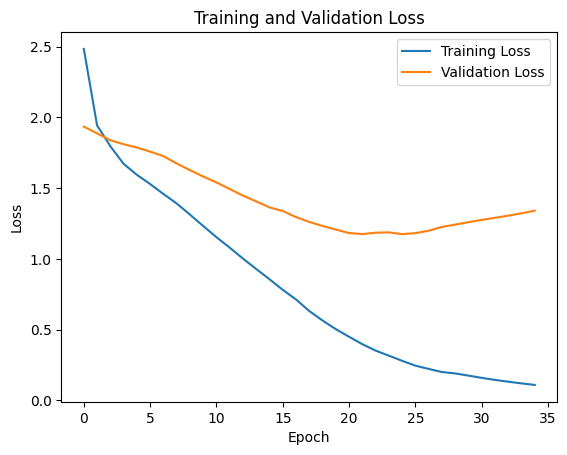

Model saved to models/gcnesn_v2_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.27GB
Average Memory Usage: 2.83GB

Total Training Time: 0.41s
Max CPU Usage: 2.50GB
Max Memory Usage: 2.83GB


In [98]:
# Create model instances
num_features = cora_dataset.num_node_features
gcnesn2_node = GCNESN_var2(num_features, 16, cora_dataset.num_classes)
print(gcnesn2_node)
print(f"Total number of trainable parameters: {gcnesn2_node.count_parameters()}\n")
train_node(gcnesn2_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcnesn_v2_node.pth')

In [112]:
num_features = cora_dataset.num_node_features
gcnesn2_node = GCNESN_var2(num_features, num_features, cora_dataset.num_classes)
train_and_evaluate_multiple_runs_node(gcnesn2_node, cora_data, path='models/multiple_run/gcnesn_v2_node.pth')

Early stopping at epoch 27

Run 1/50 -> Loss: 0.08668609708547592
  Total Training Time: 9.18s, Avg CPU Usage: 2.59GB, Avg Memory Usage: 2.70GB, Max CPU Usage: 4.16GB, Max Memory Usage: 2.78GB
  Accuracy: 0.9595, Sensitivity: 0.9375, Specificity: 0.9762
Early stopping at epoch 19

Run 2/50 -> Loss: 0.15391768515110016
  Total Training Time: 6.08s, Avg CPU Usage: 2.34GB, Avg Memory Usage: 2.75GB, Max CPU Usage: 3.95GB, Max Memory Usage: 2.78GB
  Accuracy: 0.9541, Sensitivity: 0.9767, Specificity: 0.9364
Early stopping at epoch 26

Run 3/50 -> Loss: 5.9717414842452854e-05
  Total Training Time: 8.25s, Avg CPU Usage: 2.35GB, Avg Memory Usage: 2.77GB, Max CPU Usage: 3.26GB, Max Memory Usage: 2.80GB
  Accuracy: 0.9458, Sensitivity: 0.9067, Specificity: 0.9780
Early stopping at epoch 12

Run 4/50 -> Loss: 0.06274637579917908
  Total Training Time: 3.80s, Avg CPU Usage: 1.87GB, Avg Memory Usage: 2.78GB, Max CPU Usage: 3.06GB, Max Memory Usage: 2.80GB
  Accuracy: 0.9400, Sensitivity: 0.9767, S

## Evaluation

In [116]:
print('Model 1-Layer GCN')
gcn1_node = GCN1Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
gcn1_node.load_state_dict(torch.load('models/gcn_1l_node.pth'))
test_node(gcn1_node, cora_data, cora_data.test_mask)

print('\nModel 2-Layer GCN')
gcn2_node = GCN2Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
gcn2_node.load_state_dict(torch.load('models/gcn_2l_node.pth'))
test_node(gcn2_node, cora_data, cora_data.test_mask)

num_features = cora_dataset.num_node_features
print('\nModel GCESN Var-1')
gcesn1_node = GCESN_var1(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
gcesn1_node.load_state_dict(torch.load('models/gcesn_v1_node.pth'))
test_node(gcesn1_node, cora_data, cora_data.test_mask)

print('\nModel GCESN Var-2')
gcesn2_node = GCESN_var2(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
gcesn2_node.load_state_dict(torch.load('models/gcesn_v2_node.pth'))
test_node(gcesn2_node, cora_data, cora_data.test_mask)

print('\nModel GCN-ESN Var-1')
gcnesn1_node = GCNESN_var1(num_features, 16, cora_dataset.num_classes)
gcnesn1_node.load_state_dict(torch.load('models/gcnesn_v1_node.pth'))
test_node(gcnesn1_node, cora_data, cora_data.test_mask)

print('\nModel GCN-ESN Var-2')
gcnesn2_node = GCNESN_var2(num_features, 16, cora_dataset.num_classes)
gcnesn2_node.load_state_dict(torch.load('models/gcnesn_v2_node.pth'))
test_node(gcnesn2_node, cora_data, cora_data.test_mask)

Model 1-Layer GCN
Accuracy: 0.9603
Sensitivity: 0.9692
Specificity: 0.9508

Model 2-Layer GCN
Accuracy: 0.8418
Sensitivity: 0.8590
Specificity: 0.8250

Model GCESN Var-1
Accuracy: 0.8364
Sensitivity: 1.0000
Specificity: 0.7568

Model GCESN Var-2
Accuracy: 0.9357
Sensitivity: 0.9000
Specificity: 0.9714

Model GCN-ESN Var-1
Accuracy: 0.9267
Sensitivity: 0.8871
Specificity: 0.9545

Model GCN-ESN Var-2
Accuracy: 0.9565
Sensitivity: 0.9730
Specificity: 0.9375


In [115]:
def measure_inference_performance(model, data, mask):
    model.eval()
    inference_times = []
    cpu_usages = []
    memory_usages = []

    with torch.no_grad():
        x, edge_index, batch = data.x, data.edge_index, data.batch
        adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)

        start_time = time.time()
        cpu_start = psutil.cpu_percent(interval=None)
        mem_start = psutil.virtual_memory().used

        output = model(x, adj_matrix)

        cpu_end = psutil.cpu_percent(interval=None)
        mem_end = psutil.virtual_memory().used
        end_time = time.time()

        inference_times.append(end_time - start_time)
        cpu_usages.append((cpu_end - cpu_start) / 100 * psutil.virtual_memory().total / (1024**2))
        memory_usages.append((mem_end - mem_start) / (1024**2))

    avg_inference_time = np.mean(inference_times)
    avg_cpu_usage = np.mean(cpu_usages)
    avg_memory_usage = np.mean(memory_usages)

    print(f'Average Inference Time: {avg_inference_time:.6f}s')
    print(f'Average CPU Usage: {avg_cpu_usage:.6f}MB')
    print(f'Average Memory Usage: {avg_memory_usage:.6f}MB')

    return
    # return avg_inference_time, avg_cpu_usage, avg_memory_usage

In [101]:
print('\nInference 1-Layer GCN:')
measure_inference_performance(gcn1_node, cora_data, cora_data.test_mask)

print('\nInference 2-Layer GCN:')
measure_inference_performance(gcn2_node, cora_data, cora_data.test_mask)

print('\nInference GCESN Var-1:')
measure_inference_performance(gcesn1_node, cora_data, cora_data.test_mask)

print('\nInference GCESN Var-2:')
measure_inference_performance(gcesn2_node, cora_data, cora_data.test_mask)

print('\nInference GCNESN Var-1:')
measure_inference_performance(gcnesn1_node, cora_data, cora_data.test_mask)

print('\nInference GCNESN Var-2:')
measure_inference_performance(gcnesn2_node, cora_data, cora_data.test_mask)


Inference 1-Layer GCN:
Average Inference Time: 0.005733s
Average CPU Usage: 4423.680000MB
Average Memory Usage: 1.234375MB

Inference 2-Layer GCN:
Average Inference Time: 0.006677s
Average CPU Usage: -1638.400000MB
Average Memory Usage: 0.000000MB

Inference GCESN Var-1:
Average Inference Time: 0.110963s
Average CPU Usage: -4096.000000MB
Average Memory Usage: 0.000000MB

Inference GCESN Var-2:
Average Inference Time: 0.134931s
Average CPU Usage: 0.000000MB
Average Memory Usage: 0.000000MB

Inference GCNESN Var-1:
Average Inference Time: 0.006206s
Average CPU Usage: 0.000000MB
Average Memory Usage: 0.000000MB

Inference GCNESN Var-2:
Average Inference Time: 0.006377s
Average CPU Usage: 0.000000MB
Average Memory Usage: 0.000000MB
